## model using
### begin from this(read data which had been saved)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt


from tqdm import tqdm
from io import StringIO
from contextlib import redirect_stdout
import logging
logging.getLogger('implied_vol_solver').setLevel(logging.WARNING)  # 只显示警告和错误
from tqdm import tqdm

from implied_vol_solver import CDSImpliedVolatilitySolver, CDSQuoteType
from options_optimizer import EquityOption, OptionType, EQ_OPTION_PRICING_FACTOR

### Specify As of Date

In [2]:
as_of_date = '2024-12-31'

---

### CGM stuff - Implied vol and generateing stock table

In [3]:
cgm_df = pd.read_csv('res/input_data.csv',index_col='date')
cgm_df = cgm_df.loc[[as_of_date]]

In [4]:
cgm_df

,ticker,batch,shortname,redcode,sector,region,country,avrating,impliedrating,tier,currency,docclause,primarycurve,primarypricetype,runningcoupon,primarycoupon,tenor,parspread,convspreard,upfront,cdsrealrecovery,cdsassumedrecovery,carriedforward,compositedepth5y,primarydepthcontributed,primarydepthpassed,primarydepthpassed1wma,primarydepthpassed1mma,primarydepthpassed2mma,compositepricerating,compositecurverating,hasclearsubmissions,hasquotes,hasbankcontributions,clearingsubmissionsdepthcontr,quotesdepthcontr,bankcontributionsdepthcontr,clearingsubmissionsdepthpassed,quotesdepthpassed,bankcontributionsdepthpassed,dailyupdatefrequency,maxdailymovement,_52wkhigh5y,_52wklow5y,contrstddevpassedrecovery,contrlqrangepassed,contrlqrangepassedrecovery,contr10thpctlpassed,contr10pctlpassedrecovery,contr90thpctlpassed,contr90thpctlpassedrecovery,contrmaxminrangepassed,contrmaxminrangepassedrecovery,tierbasis,isdabasis,ccybasis,docclausebasis,tierbasiscarriedforward,tierbasisdepthpassed,tierbasisstddevpassed,tierbasis10thpctlpassed,tierbasis90thpctlpassed,isdabasiscarriedforward,isdabasisdepthpassed,isdabasisstddevpassed,isdabasis10thpctlpassed,isdabasis90thpctlpassed,ccybasiscarriedforward,ccybasisdepthpassed,ccybasisstddevpassed,ccybasis10thpctlpassed,ccybasis90thpctlpassed,docclausebasiscarriedforward,docclausebasisdepthpassed,docclausebasisstddevpassed,docclausebasis10thpctlpassed,docclausebasis90thpctlpassed,tenorbasisdepthpassed,tenorbasisstddevpassed,tenorbasis10thpctlpassed,tenorbasis90thpctlpassed,idxmember,dealersclearingcountcruve,dealersclearingcountcurve1wma,dealersclearingcountcurve1mma,dealersclearingcountcurve2mma,dealersquotescountcurve,dealersquotescountcurve1wma,dealersquotescountcurve1mma,dealersquotescountcurve2mma,quotescountcurve,quotescountcurve1wma,quotescountcurve1mma,quotescountcurve2mma,dealersquotescounttenor,dealersquotescounttenor1wma,dealersquotescounttenor1mma,dealersquotescounttenor2mma,quotescounttenor,quotescounttenor1wma,quotescounttenor1mma,quotescounttenor2mma,dealersborcountcurve,dealersborcountcurve1wma,dealersborcountcurve1mma,dealersborcountcurve2mma,upfrontbaspreadaverage,upfrontbaspreadaverage1wma,upfrontbaspreadaverage1mma,upfrontbaspreadaverage2mma,upfrontbaspreadhigh,upfrontbaspreadhigh1wma,upfrontbaspreadhigh1mma,upfrontbaspreadhigh2mma,convbaspreadaverage,convbaspreadaverage1wma,convbaspreadaverage1mma,convbaspreadaverage2mma,convbaspreadhigh,convbaspreadhigh1wma,convbaspreadhigh1mma,convbaspreadhigh2mma,bidasktype5y,baspreaddepthpassed,upfrontbaspreadstddevpassed,upfrontbaspread10thpctlpassed,upfrontbaspread90thpctlpassed,convbaspreadstddevpassed,convbaspread10thpctlpassed,convbaspread90thpctlpassed,estimatednotional,curveliquidityscore,curveliquidityscore1wma,curveliquidityscore1mma,curveliquidityscore2mma,sec4lastupdate,wklygnsec4,wklygnsec41mma,wklygnsec42mma,wklycontrctsec4,wklycontrctsec41mma,wklycontrctsec42mma,gnxtrd,gnxtrd1mma,gnxtrd2mma,tbl6lastupdate,wklygrossnotional,wklygrossnotional1m,wklygrossnotional1y,wklynetnotional,wklynetnotional1m,wklynetnotional1y,wklycontr,wklycontr1m,wklycontr1y,creditdv01,riskypv01,irdv01,rec01,dp,jtd,dtz,stock_price,financial_debt_ratio
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-31,XRX,EOD,Xerox Corp,9HC533,Technology,N.Amer,United States,B,CCC,SNRFOR,USD,XR14,Y,Upfront,0.01,Y,5Y,0.057704,0.061458,0.184508,0.4,0.4,0.0,4.0,13.0,4.0,4.0,4.0,4.0,A,A,NaN,Y,Y,6.0,2.0,5.0,2.0,1.0,1.0,23.0,0.001088,NaN,NaN,0.0,1.003919,1.0,0.183689,NaN,0.185174,0.4,0.001995,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Both,6.0,6.0,6.0,6.0,1.0,1.0,3.0,4.0,132.0,110.0,576.0,647.0,1.0,1.0,3.0,4.0,30.0,25.0,120.0,142.0,12.0,12.0,12.0,12.0,0.012601,0.010624,0.011922,0.012439,0.01476,0.013427,0.01379,0.014492,0.004338,0.003659,0.004135,0.004364,0.005081,0.004624,0.00478,0.005

In [5]:
# implied vol calculation
# S = 100.0        # stock price
# D = 150.0        # debt per share
t = 5.0          # CDS tenor
r = 0.05         # risk free rate
R = 0.4          # recovery rate
L = 0.5          # loss given default
lamb = 0.3       # barrier deviation
notional = -1_000_000  # negative for sell CDS protection/buy stock      
cds_coupon = 0.01
# in practice, the below are chosen based on liquidity of hedging options, expected range of stock movement, among other things
min_stk_px = 7.
max_stk_px = 15.


In [6]:

# create new columns
cgm_df['implied_vol'] = np.nan 
cgm_df['par_spread_error'] = np.nan
solver = CDSImpliedVolatilitySolver(t, r, L, lamb, CDSQuoteType.UPFRONT)

with redirect_stdout(StringIO()):
    for i, row in tqdm(cgm_df.iterrows()):
        # imply vol by CDS upfront
        market_cds_upfront = row['upfront']
        cds_coupon = row['runningcoupon']
        R = row['cdsassumedrecovery']
        D = row['financial_debt_ratio']
        S = row['stock_price']
        implied_vol, error = solver.solve_implied_volatility(S, D, market_cds_upfront, cds_coupon, R, method='brent')
        cgm_df.at[i, 'implied_vol'] = implied_vol
        cgm_df.at[i, 'par_spread_error'] = error

1it [00:00, 181.41it/s]


In [7]:
from generate_daily_hedge_maps import generate_daily_stock_share_maps

# 使用已有的df(output_data.csv)
stock_share_maps = generate_daily_stock_share_maps(
    cgm_df, 
    t=t, 
    r=r, 
    L=L, 
    lamb=lamb, 
    notional = notional, # negative for sell CDS protection/buy stock
    min_price = min_stk_px,
    max_price = max_stk_px,
    output_dir='res/hedge_maps'
)


Generating hedge maps: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


In [8]:
sample_map = list(stock_share_maps.values())[-1]
# sample_map


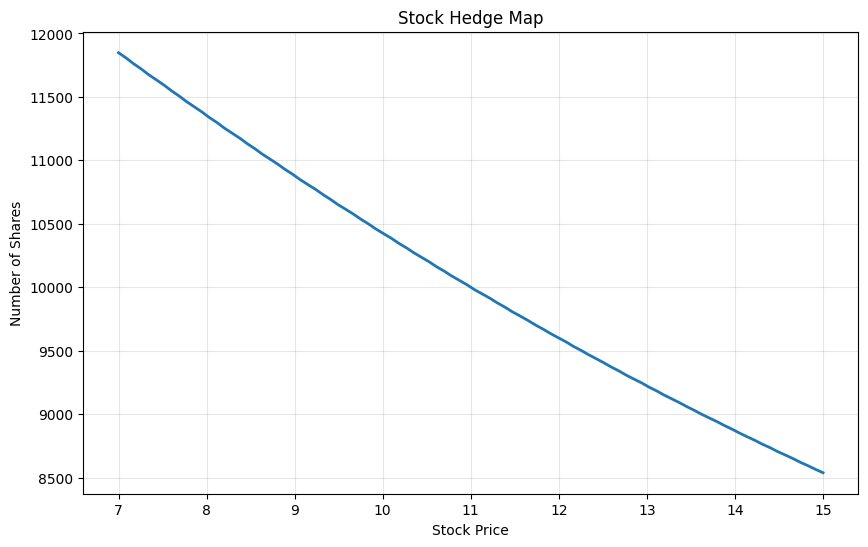

In [9]:
# Plot the hedge map
plt.figure(figsize=(10, 6))
prices = list(sample_map.keys())
shares = list(sample_map.values())
plt.plot(prices, shares, linewidth=2)
plt.xlabel('Stock Price')
plt.ylabel('Number of Shares')
plt.title('Stock Hedge Map')
plt.grid(True, alpha=0.3)
plt.show()


In [10]:
min_stk_shares = sample_map[min_stk_px]
# min_stk_shares 

---

### Choosing the hedging OTM put option

In [11]:
# Read the options data from CSV file
options_df = pd.read_csv('opt_stock_data/opt_data_XRX.csv')

# massage data
options_df['date'] = pd.to_datetime(options_df['date'])
options_df = options_df.sort_values('date')
options_df['expiration_date'] = pd.to_datetime(options_df['expiration_date'])
options_df['expiry_in_years'] = (options_df['expiration_date'] - options_df['date']).dt.days / 365.25
options_df['stock_price'] = options_df['und_day_close']
options_df['option_price'] = options_df['day_close']
options_df['implied_vol'] = options_df['iv']


In [12]:
options_df = options_df.loc[(options_df.date == as_of_date)&(options_df.option_type.str.upper()=='P')]
options_df

,date,und_ticker,ticker,option_type,strike_price,expiration_date,day_open,day_high,day_low,day_close,day_volume,day_txs,und_day_close,iv,delta,gamma,vega,theta,open_interest,expiry_in_years,stock_price,option_price,implied_vol
28405,2024-12-31,XRX,O:XRX250221P00009000,P,9,2025-02-21,0.85,0.85,0.85,0.85,1,1,8.43,0.393443,-0.642940,0.297992,0.011870,-0.004491,20.0,0.142368,8.43,0.85,0.393443
28403,2024-12-31,XRX,O:XRX250221P00007000,P,7,2025-02-21,0.20,0.20,0.20,0.20,3,1,8.43,0.599036,-0.174848,0.135165,0.008198,-0.004722,22.0,0.142368,8.43,0.20,0.599036
28404,2024-12-31,XRX,O:XRX250221P00008000,P,8,2025-02-21,0.45,0.50,0.45,0.50,14,5,8.43,0.562139,-0.362104,0.209580,0.011928,-0.006447,3700.0,0.142368,8.43,0.50,0.562139
28396,2024-12-31,XRX,O:XRX250117P00017000,P,17,2025-01-17,8.30,8.30,8.30,8.30,1,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,1415.0,0.046543,8.43,8.30,0.000005
28394,2024-12-31,XRX,O:XRX250117P00011000,P,11,2025-01-17,2.25,2.25,2.25,2.25,2,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,269.0,0.046543,8.43,2.25,0.000005
28393,2024-12-31,XRX,O:XRX250117P00010000,P,10,2025-01-17,1.23,1.23,1.23,1.23,3,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,6690.0,0.046543,8.43,1.23,0.000005
28392,2024-12-31,XRX,O:XRX250117P00008000,P,8,2025-01-17,0.13,0.17,0.13,0.17,2,2,8.43,0.485244,-0.290370,0.387977,0.006231,-0.008893,14552.0,0.046543,8.43,0.17,0.485244
28391,2024-12-31,XRX,O:XRX250117P00007000,P,7,2025-01-17,0.01,0.01,0.01,0.01,1,1,8.43,0.468106,-0.029343,0.078441,0.001215,-0.001673,23052.0,0.046543,8.43,0.01,0.468106
28395,2024-12-31,XRX,O:XRX250117P00012000,P,12,2025-01-17,3.28,3.28,3.28,3.28,1,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,126.0,0.046543,8.43,3.28,0.000005


### Check if the BS delta calc is working - bs_delta should be close to delta: see abs_delta_diff_check

In [13]:
def calculate_bs_delta_for_row(row):
    """Calculate Black-Scholes delta for a single row of options data."""
    assert row['option_type'].upper() in {'C', 'P'}, "Invalid option type"
    option_type = OptionType.CALL if row['option_type'].upper() == 'C' else OptionType.PUT
    
    # Create EquityOption instance
    option = EquityOption(
        strike=row['strike_price'],
        expiry_in_years=row['expiry_in_years'],
        option_type=option_type,
        implied_vol=row['implied_vol'],
        option_price=row['option_price']
    )
    
    # Calculate Black-Scholes delta using the stock price from the row
    bs_delta = option.calculate_bs_delta(stock_price=row['stock_price'], interest_rate=0.0)
    return bs_delta

# Add bs_delta column to the options dataframe
options_df['bs_delta'] = options_df.apply(calculate_bs_delta_for_row, axis=1)
options_df['abs_delta_diff_check'] = abs(options_df['bs_delta'] - options_df['delta'])

In [14]:
options_df.sort_values('strike_price')

,date,und_ticker,ticker,option_type,strike_price,expiration_date,day_open,day_high,day_low,day_close,day_volume,day_txs,und_day_close,iv,delta,gamma,vega,theta,open_interest,expiry_in_years,stock_price,option_price,implied_vol,bs_delta,abs_delta_diff_check
28403,2024-12-31,XRX,O:XRX250221P00007000,P,7,2025-02-21,0.20,0.20,0.20,0.20,3,1,8.43,0.599036,-0.174848,0.135165,0.008198,-0.004722,22.0,0.142368,8.43,0.20,0.599036,-0.174785,0.000063
28391,2024-12-31,XRX,O:XRX250117P00007000,P,7,2025-01-17,0.01,0.01,0.01,0.01,1,1,8.43,0.468106,-0.029343,0.078441,0.001215,-0.001673,23052.0,0.046543,8.43,0.01,0.468106,-0.029302,0.000041
28392,2024-12-31,XRX,O:XRX250117P00008000,P,8,2025-01-17,0.13,0.17,0.13,0.17,2,2,8.43,0.485244,-0.290370,0.387977,0.006231,-0.008893,14552.0,0.046543,8.43,0.17,0.485244,-0.290317,0.000053
28404,2024-12-31,XRX,O:XRX250221P00008000,P,8,2025-02-21,0.45,0.50,0.45,0.50,14,5,8.43,0.562139,-0.362104,0.209580,0.011928,-0.006447,3700.0,0.142368,8.43,0.50,0.562139,-0.362086,0.000018
28405,2024-12-31,XRX,O:XRX250221P00009000,P,9,2025-02-21,0.85,0.85,0.85,0.85,1,1,8.43,0.393443,-0.642940,0.297992,0.011870,-0.004491,20.0,0.142368,8.43,0.85,0.393443,-0.643006,0.000066
28393,2024-12-31,XRX,O:XRX250117P00010000,P,10,2025-01-17,1.23,1.23,1.23,1.23,3,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,6690.0,0.046543,8.43,1.23,0.000005,-1.000000,0.000000
28394,2024-12-31,XRX,O:XRX250117P00011000,P,11,2025-01-17,2.25,2.25,2.25,2.25,2,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,269.0,0.046543,8.43,2.25,0.000005,-1.000000,0.000000
28395,2024-12-31,XRX,O:XRX250117P00012000,P,12,2025-01-17,3.28,3.28,3.28,3.28,1,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,126.0,0.046543,8.43,3.28,0.000005,-1.000000,0.000000
28396,2024-12-31,XRX,O:XRX250117P00017000,P,17,2025-01-17,8.30,8.30,8.30,8.30,1,1,8.43,0.000005,-1.000000,0.000000,0.000000,0.000000,1415.0,0.046543,8.43,8.30,0.000005,-1.000000,0.000000


### Manually choose the most OTM and longest tenor option available, for illustrations

In [15]:
idx = 1
chosen_option = options_df.iloc[idx]
option_type = OptionType.CALL if chosen_option['option_type'].upper() == 'C' else OptionType.PUT
# Create EquityOption instance
option = EquityOption(
    strike=chosen_option['strike_price'],
    expiry_in_years=chosen_option['expiry_in_years'],
    option_type=option_type,
    implied_vol=chosen_option['implied_vol'],
    option_price=chosen_option['option_price']
)
num_contracts = abs(int(min_stk_shares / (option.calculate_bs_delta() * EQ_OPTION_PRICING_FACTOR)))
option.set_number_contracts(num_contracts)
equiv_stk_shares = option.equivalent_stock_shares(stock_price_grids=sample_map.keys())
equiv_stk_shares

{np.float64(7.0): -11830,
 np.float64(7.09): -11250,
 np.float64(7.17): -10745,
 np.float64(7.26): -10189,
 np.float64(7.34): -9709,
 np.float64(7.43): -9182,
 np.float64(7.52): -8673,
 np.float64(7.6): -8235,
 np.float64(7.69): -7759,
 np.float64(7.77): -7351,
 np.float64(7.86): -6910,
 np.float64(7.95): -6487,
 np.float64(8.03): -6127,
 np.float64(8.12): -5740,
 np.float64(8.2): -5411,
 np.float64(8.29): -5058,
 np.float64(8.38): -4723,
 np.float64(8.46): -4440,
 np.float64(8.55): -4138,
 np.float64(8.63): -3883,
 np.float64(8.72): -3613,
 np.float64(8.81): -3357,
 np.float64(8.89): -3143,
 np.float64(8.98): -2917,
 np.float64(9.06): -2727,
 np.float64(9.15): -2526,
 np.float64(9.24): -2338,
 np.float64(9.32): -2181,
 np.float64(9.41): -2015,
 np.float64(9.49): -1878,
 np.float64(9.58): -1733,
 np.float64(9.67): -1598,
 np.float64(9.75): -1486,
 np.float64(9.84): -1369,
 np.float64(9.92): -1272,
 np.float64(10.01): -1170,
 np.float64(10.1): -1075,
 np.float64(10.18): -998,
 np.float6

In [16]:
net_stk_shares = {k: sample_map[k] + equiv_stk_shares[k] for k in sample_map.keys()}
net_stk_shares

{np.float64(7.0): 18,
 np.float64(7.09): 555,
 np.float64(7.17): 1017,
 np.float64(7.26): 1530,
 np.float64(7.34): 1967,
 np.float64(7.43): 2452,
 np.float64(7.52): 2918,
 np.float64(7.6): 3314,
 np.float64(7.69): 3747,
 np.float64(7.77): 4113,
 np.float64(7.86): 4512,
 np.float64(7.95): 4893,
 np.float64(8.03): 5211,
 np.float64(8.12): 5557,
 np.float64(8.2): 5844,
 np.float64(8.29): 6156,
 np.float64(8.38): 6450,
 np.float64(8.46): 6692,
 np.float64(8.55): 6953,
 np.float64(8.63): 7167,
 np.float64(8.72): 7397,
 np.float64(8.81): 7612,
 np.float64(8.89): 7786,
 np.float64(8.98): 7972,
 np.float64(9.06): 8122,
 np.float64(9.15): 8283,
 np.float64(9.24): 8432,
 np.float64(9.32): 8550,
 np.float64(9.41): 8676,
 np.float64(9.49): 8774,
 np.float64(9.58): 8881,
 np.float64(9.67): 8977,
 np.float64(9.75): 9051,
 np.float64(9.84): 9129,
 np.float64(9.92): 9188,
 np.float64(10.01): 9252,
 np.float64(10.1): 9310,
 np.float64(10.18): 9349,
 np.float64(10.27): 9394,
 np.float64(10.35): 9424,
 n

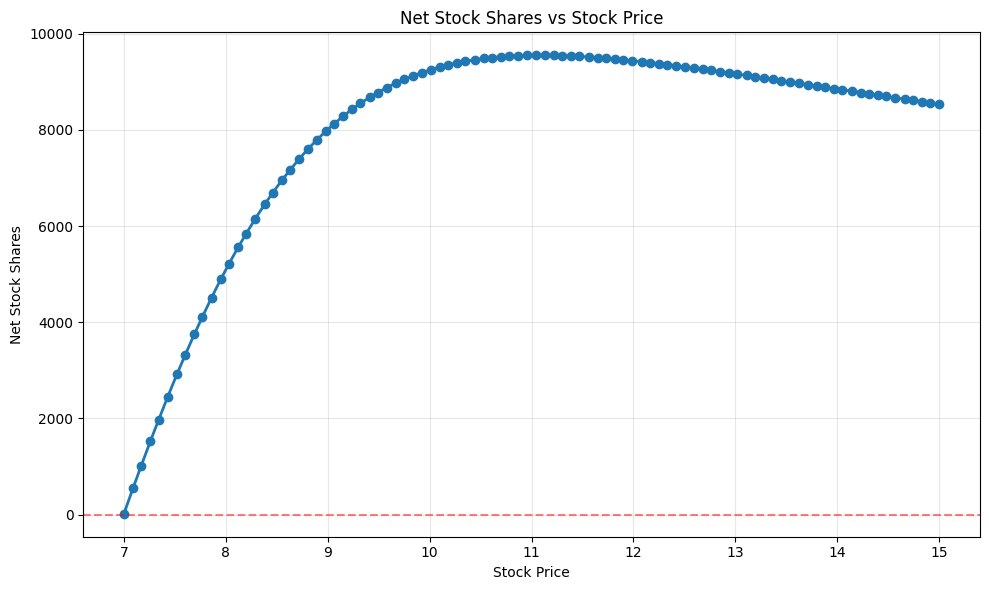

In [17]:

# Plot the net stock shares
plt.figure(figsize=(10, 6))
plt.plot(list(net_stk_shares.keys()), list(net_stk_shares.values()), marker='o', linestyle='-', linewidth=2)
plt.xlabel('Stock Price')
plt.ylabel('Net Stock Shares')
plt.title('Net Stock Shares vs Stock Price')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
